In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import dask.dataframe as dd
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
def assemble_location_summary(site_name):
    location_df = dd.read_csv(f'../data/continuous/{site_name}/*.csv').compute()
    location_df['ref_start_time'] = pd.to_datetime(location_df['input_file'], format='%Y%m%d_%H%M%S', exact=False) + pd.to_timedelta(location_df['start_time'].values.astype('float64'), unit='S')
    location_df['ref_end_time'] = pd.to_datetime(location_df['input_file'], format='%Y%m%d_%H%M%S', exact=False) + pd.to_timedelta(location_df['end_time'].values.astype('float64'), unit='S')

    location_df.to_csv(f'../data/continuous/2022_bd2_summary/bd2__{site_name}_2022.csv')
    all_processed_filepaths = sorted(list(map(str, list(Path(f'../data/continuous/{site_name}').iterdir()))))

    all_processed_datetimes = pd.to_datetime(all_processed_filepaths, format="%Y%m%d_%H%M%S", exact=False)
    datetimes_with_calls_detected = pd.to_datetime(location_df["input_file"].unique(), format="%Y%m%d_%H%M%S", exact=False)
    num_of_detections = location_df.groupby(["input_file"])["input_file"].count()
    num_of_detections.index = datetimes_with_calls_detected

    num_of_detections = add_rows_for_absence(num_of_detections, all_processed_datetimes, datetimes_with_calls_detected)
    activity_arr = pd.DataFrame(list(zip(num_of_detections.index, num_of_detections.values)), columns=["Date_and_Time_UTC", "Number_of_Detections"])
    
    return activity_arr

def add_rows_for_absence(num_of_detections, all_processed_datetimes, datetimes_with_calls_detected):
    for file in all_processed_datetimes:
        if (not(file in datetimes_with_calls_detected)):
            num_of_detections[file] = 0
    num_of_detections = num_of_detections.sort_index()

    return num_of_detections

In [3]:
def construct_activity_grid(activity_arr):
    activity_datetimes = pd.to_datetime(activity_arr["Date_and_Time_UTC"].values)
    activity_dates = activity_datetimes.strftime("%m/%d/%y").unique()
    activity_times = activity_datetimes.strftime("%H:%M").unique()

    activity = activity_arr["Number_of_Detections"].values.reshape(len(activity_dates), len(activity_times)).T
    activity_df = pd.DataFrame(activity, index=activity_times, columns=activity_dates)

    return activity_df

def construct_presence_grid(activity_arr):
    activity_datetimes = pd.to_datetime(activity_arr["Date_and_Time_UTC"].values)
    activity_dates = activity_datetimes.strftime("%m/%d/%y").unique()
    activity_times = activity_datetimes.strftime("%H:%M").unique()

    presence_arr = activity_arr.copy()
    presence_arr["Number_of_Detections"].mask(presence_arr["Number_of_Detections"] > 0, 1, inplace=True)
    
    presence = presence_arr["Number_of_Detections"].values.reshape(len(activity_dates), len(activity_times)).T
    presence_df = pd.DataFrame(presence, index=activity_times, columns=activity_dates)

    return presence_df

In [4]:
def rect(pos):
    r = plt.Rectangle(pos-0.505, 1, 1, facecolor="none", edgecolor="k", linewidth=0.8)
    plt.gca().add_patch(r)


In [5]:
def plot_activity_grid(activity_df):

    plt.rcParams.update({'font.size': 16})
    plt.figure(figsize=(10, 10))
    plt.title(f"Activity from Telephone Field", loc='left', y=1.05)
    plt.imshow(1+activity_df, norm=colors.LogNorm(vmin=1, vmax=10e3))
    plt.yticks(np.arange(0, len(activity_df.index), 2)-0.5, activity_df.index[::2], rotation=50)
    plt.xticks(np.arange(0, len(activity_df.columns))-0.5, activity_df.columns, rotation=50)
    plt.ylabel('UTC Time (HH:MM)')
    plt.xlabel('Date (MM/DD/YY)')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

def plot_presence_grid(presence_df, color="cyan"):
    
    plt.rcParams.update({'font.size': 16})
    plt.figure(figsize=(10, 10))
    plt.title(f"Presence/Absence from Telephone Field", loc='left', y=1.05)
    masked_array = np.ma.masked_where(presence_df == 1, presence_df)
    cmap = plt.get_cmap("Greys")  # Can be any colormap that you want after the cm
    cmap.set_bad(color=color)
    im = plt.imshow(masked_array, cmap=cmap)
    x, y = np.meshgrid(np.arange(presence_df.shape[1]), np.arange(presence_df.shape[0]))
    m = np.c_[x[presence_df == 1], y[presence_df == 1]]
    for pos in m:
        rect(pos)
    plt.xlabel("UTC Time (HH:MM)")
    plt.yticks(np.arange(0, len(presence_df.index), 2)-0.5, presence_df.index[::2], rotation=50)
    plt.xticks(np.arange(0, len(presence_df.columns))-0.5, presence_df.columns, rotation=50)
    plt.grid(which="both", color='k')

    plt.tight_layout()
    plt.show()

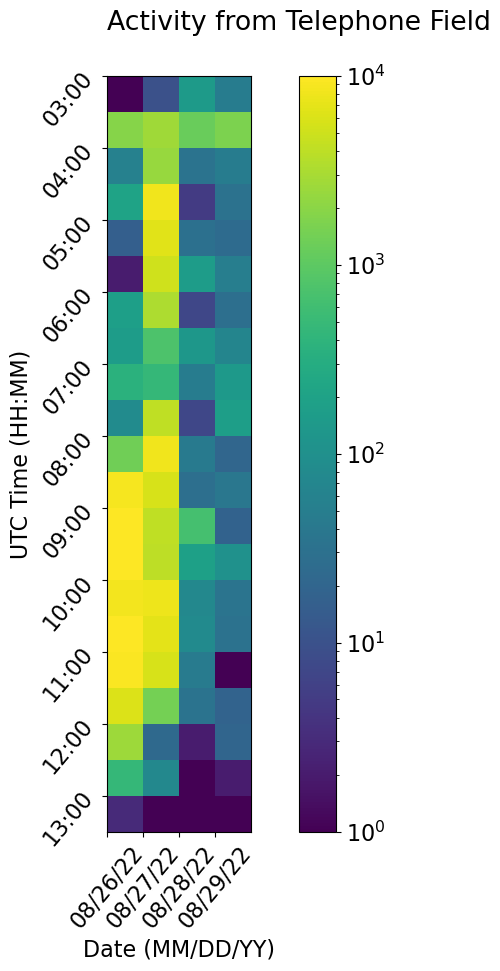

In [6]:
activity_df = construct_activity_grid(assemble_location_summary("Telephone"))
plot_activity_grid(activity_df)

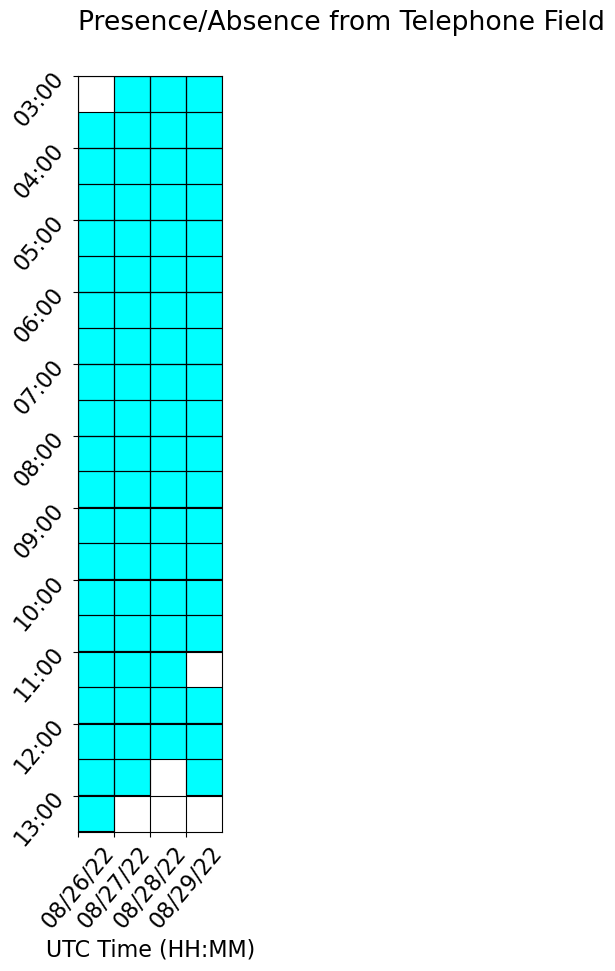

In [7]:
presence_df = construct_presence_grid(assemble_location_summary("Telephone"))
plot_presence_grid(presence_df)

In [29]:
location_df = pd.read_csv(f'../data/continuous/2022_bd2_summary/bd2__Telephone_2022.csv', index_col=0)
location_df["ref_start_time"] = pd.to_datetime(location_df["ref_start_time"], format="%Y-%m-%d %H:%M:%S.%f")
location_df["ref_end_time"] = pd.to_datetime(location_df["ref_end_time"], format="%Y-%m-%d %H:%M:%S.%f")

In [30]:
location_df

,start_time,end_time,low_freq,high_freq,event,class,class_prob,det_prob,individual,input_file,Recover Folder,SD Card,Site name,ref_start_time,ref_end_time
0,198.3085,198.3216,25468.0,33373.0,Echolocation,Eptesicus serotinus,0.305,0.619,-1,/mnt/ubna_data_01/recover-20220828/UBNA_007/20...,recover-20220828,UBNA_007,Telephone Field,2022-08-26 03:33:18.308500000,2022-08-26 03:33:18.321600
1,198.4675,198.4778,24609.0,33321.0,Echolocation,Nyctalus leisleri,0.373,0.704,-1,/mnt/ubna_data_01/recover-20220828/UBNA_007/20...,recover-20220828,UBNA_007,Telephone Field,2022-08-26 03:33:18.467500000,2022-08-26 03:33:18.477800
2,198.7335,198.7458,24609.0,33000.0,Echolocation,Eptesicus serotinus,0.310,0.651,-1,/mnt/ubna_data_01/recover-20220828/UBNA_007/20...,recover-20220828,UBNA_007,Telephone Field,2022-08-26 03:33:18.733500000,2022-08-26 03:33:18.745800
3,198.8895,198.9024,24609.0,31208.0,Echolocation,Nyctalus leisleri,0.210,0.505,-1,/mnt/ubna_data_01/recover-20220828/UBNA_007/20...,recover-20220828,UBNA_007,Telephone Field,2022-08-26 03:33:18.889500000,2022-08-26 03:33:18.902400
4,199.0485,199.0615,24609.0,30468.0,Echolocation,Nyctalus leisleri,0.252,0.514,-1,/mnt/ubna_data_01/recover-20220828/UBNA_007/20...,recover-20220828,UBNA_007,Telephone Field,2022-08-26 03:33:19.048500000,2022-08-26 03:33:19.061500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,1629.3575,1629.3660,39218.0,52961.0,Echolocation,Pipistrellus nathusii,0.370,0.509,-1,/mnt/ubna_data_01/recover-20220828/UBNA_007/20...,recover-20220828,UBNA_007,Telephone Field,2022-08-29 12:27:09.357500000,2022-08-29 12:27:09.366000
16,1629.7565,1629.7660,39218.0,52258.0,Echolocation,Pipistrellus nathusii,0.570,0.665,-1,/mnt/ubna_data_01/recover-20220828/UBNA_007/20...,recover-20220828,UBNA_007,Telephone Field,2022-08-29 12:27:09.756500000,2022-08-29 12:27:09.766000
17,1629.8565,1629.8643,38359.0,45924.0,Echolocation,Pipistrellus nathusii,0.578,0.652,-1,/mnt/ubna_data_01/recover-20220828/UBNA_007/20...,recover-20220828,UBNA_007,Telephone Field,2022-08-29 12:27:09.856500000,2022-08-29 12:27:09.864300
18,1630.5035,1630.5117,38359.0,46024.0,Echolocation,Pipistrellus nathusii,0.423,0.555,-1,/mnt/ubna_data_01/recover-20220828/UBNA_007/20...,recover-20220828,UBNA_007,Telephone Field,2022-08-29 12:27:10.503499999,2022-08-29 12:27:10.511700


In [51]:
gk = location_df.resample("30T", on='ref_start_time')
gk.first()

,start_time,end_time,low_freq,high_freq,event,class,class_prob,det_prob,individual,input_file,Recover Folder,SD Card,Site name,ref_end_time
ref_start_time,,,,,,,,,,,,,,
2022-08-26 03:30:00,198.3085,198.3216,25468.0,33373.0,Echolocation,Eptesicus serotinus,0.305,0.619,-1.0,/mnt/ubna_data_01/recover-20220828/UBNA_007/20...,recover-20220828,UBNA_007,Telephone Field,2022-08-26 03:33:18.321600
2022-08-26 04:00:00,0.5175,0.5248,40078.0,49465.0,Echolocation,Pipistrellus nathusii,0.552,0.626,-1.0,/mnt/ubna_data_01/recover-20220828/UBNA_007/20...,recover-20220828,UBNA_007,Telephone Field,2022-08-26 04:00:00.524800
2022-08-26 04:30:00,1096.8865,1096.8946,39218.0,49174.0,Echolocation,Pipistrellus nathusii,0.604,0.655,-1.0,/mnt/ubna_data_01/recover-20220828/UBNA_007/20...,recover-20220828,UBNA_007,Telephone Field,2022-08-26 04:48:16.894600
2022-08-26 05:00:00,397.4305,397.4360,47812.0,62385.0,Echolocation,Pipistrellus pipistrellus,0.524,0.600,-1.0,/mnt/ubna_data_01/recover-20220828/UBNA_007/20...,recover-20220828,UBNA_007,Telephone Field,2022-08-26 05:06:37.436000
2022-08-26 05:30:00,696.3645,696.3723,40078.0,48050.0,Echolocation,Pipistrellus nathusii,0.287,0.528,-1.0,/mnt/ubna_data_01/recover-20220828/UBNA_007/20...,recover-20220828,UBNA_007,Telephone Field,2022-08-26 05:41:36.372300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-29 10:30:00,424.4615,424.4663,49531.0,58558.0,Echolocation,Pipistrellus pipistrellus,0.496,0.572,-1.0,/mnt/ubna_data_01/recover-20220828/UBNA_007/20...,recover-20220828,UBNA_007,Telephone Field,2022-08-29 10:37:04.466300
2022-08-29 11:00:00,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,None,None,None,None,NaT
2022-08-29 11:30:00,1016.3655,1016.3708,47812.0,58435.0,Echolocation,Pipistrellus pipistrellus,0.560,0.583,-1.0,/mnt/ubna_data_01/recover-20220828/UBNA_007/20...,recover-20220828,UBNA_007,Telephone Field,2022-08-29 11:46:56.370800


In [52]:
gk.get_group('2022-08-26 03:30:00')

,start_time,end_time,low_freq,high_freq,event,class,class_prob,det_prob,individual,input_file,Recover Folder,SD Card,Site name,ref_start_time,ref_end_time
0,198.3085,198.3216,25468.0,33373.0,Echolocation,Eptesicus serotinus,0.305,0.619,-1,/mnt/ubna_data_01/recover-20220828/UBNA_007/20...,recover-20220828,UBNA_007,Telephone Field,2022-08-26 03:33:18.308500,2022-08-26 03:33:18.321600000
1,198.4675,198.4778,24609.0,33321.0,Echolocation,Nyctalus leisleri,0.373,0.704,-1,/mnt/ubna_data_01/recover-20220828/UBNA_007/20...,recover-20220828,UBNA_007,Telephone Field,2022-08-26 03:33:18.467500,2022-08-26 03:33:18.477800000
2,198.7335,198.7458,24609.0,33000.0,Echolocation,Eptesicus serotinus,0.310,0.651,-1,/mnt/ubna_data_01/recover-20220828/UBNA_007/20...,recover-20220828,UBNA_007,Telephone Field,2022-08-26 03:33:18.733500,2022-08-26 03:33:18.745800000
3,198.8895,198.9024,24609.0,31208.0,Echolocation,Nyctalus leisleri,0.210,0.505,-1,/mnt/ubna_data_01/recover-20220828/UBNA_007/20...,recover-20220828,UBNA_007,Telephone Field,2022-08-26 03:33:18.889500,2022-08-26 03:33:18.902400000
4,199.0485,199.0615,24609.0,30468.0,Echolocation,Nyctalus leisleri,0.252,0.514,-1,/mnt/ubna_data_01/recover-20220828/UBNA_007/20...,recover-20220828,UBNA_007,Telephone Field,2022-08-26 03:33:19.048500,2022-08-26 03:33:19.061500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1895,1683.0945,1683.1031,35781.0,42999.0,Echolocation,Pipistrellus nathusii,0.466,0.559,-1,/mnt/ubna_data_01/recover-20220828/UBNA_007/20...,recover-20220828,UBNA_007,Telephone Field,2022-08-26 03:58:03.094500,2022-08-26 03:58:03.103100000
1896,1683.3015,1683.3089,36640.0,44571.0,Echolocation,Pipistrellus nathusii,0.426,0.580,-1,/mnt/ubna_data_01/recover-20220828/UBNA_007/20...,recover-20220828,UBNA_007,Telephone Field,2022-08-26 03:58:03.301500,2022-08-26 03:58:03.308900000
1897,1683.4065,1683.4140,35781.0,53412.0,Echolocation,Pipistrellus nathusii,0.299,0.503,-1,/mnt/ubna_data_01/recover-20220828/UBNA_007/20...,recover-20220828,UBNA_007,Telephone Field,2022-08-26 03:58:03.406500,2022-08-26 03:58:03.414000000
1898,1683.4985,1683.5065,36640.0,44583.0,Echolocation,Pipistrellus nathusii,0.321,0.507,-1,/mnt/ubna_data_01/recover-20220828/UBNA_007/20...,recover-20220828,UBNA_007,Telephone Field,2022-08-26 03:58:03.498500,2022-08-26 03:58:03.506499999


In [53]:
gk.apply(lambda x: x.loc[x['start_time'] <= 360])

,start_time,end_time,low_freq,high_freq,event,class,class_prob,det_prob,individual,input_file,Recover Folder,SD Card,Site name,ref_end_time
0,198.3085,198.3216,25468.0,33373.0,Echolocation,Eptesicus serotinus,0.305,0.619,-1,/mnt/ubna_data_01/recover-20220828/UBNA_007/20...,recover-20220828,UBNA_007,Telephone Field,2022-08-26 03:33:18.321600
1,198.4675,198.4778,24609.0,33321.0,Echolocation,Nyctalus leisleri,0.373,0.704,-1,/mnt/ubna_data_01/recover-20220828/UBNA_007/20...,recover-20220828,UBNA_007,Telephone Field,2022-08-26 03:33:18.477800
2,198.7335,198.7458,24609.0,33000.0,Echolocation,Eptesicus serotinus,0.310,0.651,-1,/mnt/ubna_data_01/recover-20220828/UBNA_007/20...,recover-20220828,UBNA_007,Telephone Field,2022-08-26 03:33:18.745800
3,198.8895,198.9024,24609.0,31208.0,Echolocation,Nyctalus leisleri,0.210,0.505,-1,/mnt/ubna_data_01/recover-20220828/UBNA_007/20...,recover-20220828,UBNA_007,Telephone Field,2022-08-26 03:33:18.902400
4,199.0485,199.0615,24609.0,30468.0,Echolocation,Nyctalus leisleri,0.252,0.514,-1,/mnt/ubna_data_01/recover-20220828/UBNA_007/20...,recover-20220828,UBNA_007,Telephone Field,2022-08-26 03:33:19.061500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,194.2325,194.2383,40937.0,51979.0,Echolocation,Pipistrellus nathusii,0.372,0.530,-1,/mnt/ubna_data_01/recover-20220828/UBNA_007/20...,recover-20220828,UBNA_007,Telephone Field,2022-08-29 10:03:14.238300
4,194.9705,194.9766,41796.0,50439.0,Echolocation,Pipistrellus nathusii,0.413,0.523,-1,/mnt/ubna_data_01/recover-20220828/UBNA_007/20...,recover-20220828,UBNA_007,Telephone Field,2022-08-29 10:03:14.976600
5,195.2545,195.2620,40937.0,52885.0,Echolocation,Pipistrellus nathusii,0.385,0.523,-1,/mnt/ubna_data_01/recover-20220828/UBNA_007/20...,recover-20220828,UBNA_007,Telephone Field,2022-08-29 10:03:15.262000
6,195.7205,195.7288,40937.0,54601.0,Echolocation,Pipistrellus nathusii,0.430,0.573,-1,/mnt/ubna_data_01/recover-20220828/UBNA_007/20...,recover-20220828,UBNA_007,Telephone Field,2022-08-29 10:03:15.728800
